## Benchmark for measuring performance of engineered features and models
When engineering new features and creating new models, I will need to compare new methods with benchmark to decide if there is any improvement.

In [16]:
import os
if os.name=='nt':
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [17]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [26]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', -best_mcc

In [4]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)

        clf.fit(x_train_tmp, y_train_tmp, 
                eval_set=[(x_test_tmp, y_test_tmp)], 
                eval_metric=mcc_eval, early_stopping_rounds=10,
                verbose=verbose)
        scores.append(-clf.best_score)
        n_trees.append(clf.best_ntree_limit)
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [5]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Stratified KFold CV with repeated models
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=10,
                    verbose=verbose)
            n_trees.append(clf.best_ntree_limit)
            scores.append(-clf.best_score)
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [6]:
# y_train = read_pickle('y_train.pickle')

# x_train = read_pickle('x_train_numeric_date_0.pickle')

In [22]:
important_features = pd.read_csv('important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [23]:
x_train_numeric = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=important_features)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

### Compare variance of CV score between repeated stratified KFold and stratified KFold with repeated models

In [10]:
n_estimators = 200
clf = XGBClassifier(max_depth=4, n_estimators=n_estimators, 
                    base_score=0.0058, n_jobs=-1, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03)

In [11]:
# clfs, scores, n_trees, running_time = cross_val_predict_rskf(clf, x_train_numeric, 
#    y_train, n_splits=3, n_repeats=2, random_state=42, verbose=False)

In [12]:
clfs, scores, n_trees, running_time = cross_val_predict_skf_rm(clf, x_train_numeric, 
    y_train, n_splits=5, n_repeats=3, random_state=42)
save_pickle(clfs, 'clfs_benchmark.pickle')

Repeat 0
Split 0, score = 0.215, n_best_trees = 5, total time = 0.240 min
Split 1, score = 0.230, n_best_trees = 49, total time = 1.007 min
Split 2, score = 0.224, n_best_trees = 18, total time = 1.389 min
Split 3, score = 0.211, n_best_trees = 19, total time = 1.779 min
Split 4, score = 0.217, n_best_trees = 17, total time = 2.146 min
Repeat 1
Split 0, score = 0.211, n_best_trees = 21, total time = 2.564 min
Split 1, score = 0.217, n_best_trees = 28, total time = 3.060 min
Split 2, score = 0.216, n_best_trees = 26, total time = 3.536 min
Split 3, score = 0.227, n_best_trees = 18, total time = 3.912 min
Split 4, score = 0.222, n_best_trees = 56, total time = 4.737 min
Repeat 2
Split 0, score = 0.227, n_best_trees = 33, total time = 5.292 min
Split 1, score = 0.222, n_best_trees = 68, total time = 6.275 min
Split 2, score = 0.212, n_best_trees = 56, total time = 7.103 min
Split 3, score = 0.222, n_best_trees = 55, total time = 7.923 min
Split 4, score = 0.214, n_best_trees = 45, total t

### Calculate `n_trees` for training the whole dataset

In [18]:
results = read_pickle('results_benchmark.pickle')

In [21]:
np.mean(results['n_trees'])*5/4

59.25

In [75]:
np.mean(results['scores'])

0.22889219999999993

### Train on the whole dataset

In [ ]:
n_estimators = 60
clf = XGBClassifier(max_depth=14, n_estimators=n_estimators, 
                    base_score=0.0058, n_jobs=-1, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03)
clf.fit(x_train_numeric, y_train, 
        eval_set=[(x_train_numeric, y_train)], 
        eval_metric=mcc_eval, verbose=True)

[0]	validation_0-error:0.005811	validation_0-MCC:-0.172025
[1]	validation_0-error:0.005811	validation_0-MCC:-0.186038
[2]	validation_0-error:0.005811	validation_0-MCC:-0.205032
[3]	validation_0-error:0.005811	validation_0-MCC:-0.212484
[4]	validation_0-error:0.005811	validation_0-MCC:-0.213678
[5]	validation_0-error:0.005811	validation_0-MCC:-0.216577
[6]	validation_0-error:0.005811	validation_0-MCC:-0.221166
[7]	validation_0-error:0.005811	validation_0-MCC:-0.223749
[8]	validation_0-error:0.005811	validation_0-MCC:-0.228559
[9]	validation_0-error:0.005811	validation_0-MCC:-0.231866
[10]	validation_0-error:0.005811	validation_0-MCC:-0.23456
[11]	validation_0-error:0.005811	validation_0-MCC:-0.241056
[12]	validation_0-error:0.005811	validation_0-MCC:-0.239444
[13]	validation_0-error:0.005811	validation_0-MCC:-0.244551


In [51]:
y_train_pred = clf.predict_proba(x_train_numeric)[:, 1]

0.23084896114199793


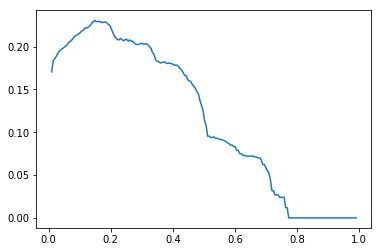

In [53]:
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [54]:
best_threshold

0.14788944723618092

In [48]:
y_test_pred = clf.predict_proba(x_test)[:, 1]
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

In [60]:
sub = pd.read_csv("data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_1_submission.csv.gz", compression="gzip")

public MCC = 0.21743, private MCC = 0.20885
CV MCC mean = 0.229, std = 0.007

### Another threshold
It is expected that 0.58% of the samples are positive, let's try such a threshold.

In [61]:
n_pos = np.array([sum(y_train_pred>thr) for thr in thresholds])

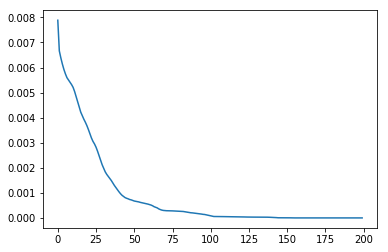

In [64]:
plt.plot(n_pos/len(y_train_pred))

In [68]:
a = np.where(n_pos/len(y_train_pred)<=0.0058)

In [70]:
thr = thresholds[a[0][0]]

In [71]:
thr

0.03462311557788945

In [76]:
y_test_pred_int = (y_test_pred>thr).astype(int)

In [77]:
sub = pd.read_csv("data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_1_submission.csv.gz", compression="gzip")

public MCC = 0.20236, private MCC = 0.19508